In [4]:
!pip install pyspark matplotlib pandas numpy seaborn

Processing /home/pierre-louis/.cache/pip/wheels/df/88/9e/58ef1f74892fef590330ca0830b5b6d995ba29b44f977b3926/pyspark-3.1.2-py2.py3-none-any.whl


# Rating some movies
#### To make recommendation for you, we are going to learn your taste by asking you to rate a few movies.

In [5]:
import sys
import os
from os import remove
from time import time
from os.path import join, isfile, dirname

topMovies = """1,Toy Story (1995)
780,Independence Day (a.k.a. ID4) (1996)
590,Dances with Wolves (1990)
1210,Star Wars: Episode VI - Return of the Jedi (1983)
648,Mission: Impossible (1996)
344,Ace Ventura: Pet Detective (1994)
165,Die Hard: With a Vengeance (1995)
153,Batman Forever (1995)
597,Pretty Woman (1990)
1580,Men in Black (1997)
231,Dumb & Dumber (1994)"""

parentDir = os.path.abspath('')
ratingsFile = join(parentDir, "personalRatings.txt")

if isfile(ratingsFile):
    r = input("Looks like you've already rated the movies. Overwrite ratings (y/N)? ")
    if r and r[0].lower() == "y":
        remove(ratingsFile)
    else:
        sys.exit()

prompt = "Please rate the following movie (1-5 (best), or 0 if not seen): "
print(prompt)

now = int(time())
n = 0

f = open(ratingsFile, 'w')
for line in topMovies.split("\n"):
    ls = line.strip().split(",")
    valid = False
    while not valid:
        rStr = input(ls[1] + ": ")
        r = int(rStr) if rStr.isdigit() else -1
        if r < 0 or r > 5:
            print(prompt)
        else:
            valid = True
            if r > 0:
                f.write("0::%s::%d::%d\n" % (ls[0], r, now))
                n += 1
f.close()

if n == 0:
    print("No rating provided!")


Looks like you've already rated the movies. Overwrite ratings (y/N)? y
Please rate the following movie (1-5 (best), or 0 if not seen): 
Toy Story (1995): 5
Independence Day (a.k.a. ID4) (1996): 5
Dances with Wolves (1990): 5
Star Wars: Episode VI - Return of the Jedi (1983): 5
Mission: Impossible (1996): 4
Ace Ventura: Pet Detective (1994): 1
Die Hard: With a Vengeance (1995): 2
Batman Forever (1995): 2
Pretty Woman (1990): 4
Men in Black (1997): 5
Dumb & Dumber (1994): 2


# Solution Structure

In [6]:
# !/usr/bin/env python

import sys
import os
import itertools
from math import sqrt
from operator import add
from os.path import join, isfile, dirname
from pyspark.sql import SparkSession
#from pyspark.mllib.recommendation import ALS
from pyspark.ml.recommendation import ALS


def parseRating(line):
    """
    Parses a rating record in MovieLens format userId::movieId::rating::timestamp .
    """
    fields = line.strip().split("::")
    return int(fields[3]) % 10, (int(fields[0]), int(fields[1]), float(fields[2]))

def _parseRating(line):
    """
    Parses a rating record in MovieLens format userId::movieId::rating::timestamp .
    """
    fields = line.strip().split("::")
    return (int(fields[0]), int(fields[1]), float(fields[2]))

def parseMovie(line):
    """
    Parses a movie record in MovieLens format movieId::movieTitle .
    """
    fields = line.strip().split("::")
    return int(fields[0]), fields[1]

def loadRatings(ratingsFile):
    """
    Load ratings from file.
    """
    if not isfile(ratingsFile):
        print("File %s does not exist." % ratingsFile)
        sys.exit(1)
    f = open(ratingsFile, 'r')
    ratings = filter(lambda r: r[2] > 0, [parseRating(line)[1] for line in f])
    f.close()
    if not ratings:
        print("No ratings provided.")
        sys.exit(1)
    else:
        return ratings

def computeRmse(model, data, n):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))

if __name__ == "__main__":

    # set up environment
    spark = SparkSession.builder \
   .master("local") \
   .appName("Movie Recommendation Engine") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
    sc = spark.sparkContext
    
    movieLensHomeDir = os.path.abspath('') + '/movielens/medium/'

    # load personal ratings
    myRatings = loadRatings(os.path.abspath('personalRatings.txt'))
    myRatingsRDD = sc.parallelize(myRatings, 1)
    
    # load ratings and movie titles

    movieLensHomeDir = os.path.abspath('') + '/movielens/medium/'
    
    # ratings is an RDD of (last digit of timestamp, (userId, movieId, rating))
    ratings = sc.textFile(join(movieLensHomeDir, "ratings.dat")).map(_parseRating)

    # movies is an RDD of (movieId, movieTitle)
    movies = sc.textFile(join(movieLensHomeDir, "movies.dat")).map(parseMovie)

    # Casting the RDD into Dataframe and visualise data to check if the data exist. 
    myRatingsDF = myRatingsRDD.toDF(["userId", "movieId", "rating"])
    moviesDF = movies.toDF(['movieID', 'movieName'])
    ratingsDF = ratings.toDF(["userId", "movieId", "rating"])
    
    myRatingsDF.show()
    ratingsDF.show()
    moviesDF.show()

21/10/16 11:28:16 WARN Utils: Your hostname, ZENBOOK-PL resolves to a loopback address: 127.0.1.1; using 172.25.144.78 instead (on interface eth0)
21/10/16 11:28:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/16 11:28:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      1|   5.0|
|     0|    780|   5.0|
|     0|    590|   5.0|
|     0|   1210|   5.0|
|     0|    648|   4.0|
|     0|    344|   1.0|
|     0|    165|   2.0|
|     0|    153|   2.0|
|     0|    597|   4.0|
|     0|   1580|   5.0|
|     0|    231|   2.0|
+------+-------+------+

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|   1193|   5.0|
|     1|    661|   3.0|
|     1|    914|   3.0|
|     1|   3408|   4.0|
|     1|   2355|   5.0|
|     1|   1197|   3.0|
|     1|   1287|   5.0|
|     1|   2804|   5.0|
|     1|    594|   4.0|
|     1|    919|   4.0|
|     1|    595|   5.0|
|     1|    938|   4.0|
|     1|   2398|   4.0|
|     1|   2918|   4.0|
|     1|   1035|   5.0|
|     1|   2791|   4.0|
|     1|   2687|   3.0|
|     1|   2018|   4.0|
|     1|   3105|   5.0|
|     1|   2797|   4.0|
+------+-------+------+
only showing top 20 rows

+-------+--------------------+
|movie

# Data Exploration

In [7]:
# Get an idea of the size of the dataset
from pyspark.sql.functions import countDistinct

nbOfMovies = moviesDF.count()
print("The database contains", nbOfMovies, "movies")

nbOfRatings = ratingsDF.count()
print("The database contains", nbOfRatings, "ratings")

nbOfUsers=ratingsDF.select(countDistinct("userId")).first()[0]
print("The database contains", nbOfUsers, "users")

The database contains 3883 movies


The database contains 1000209 ratings


The database contains 6040 users


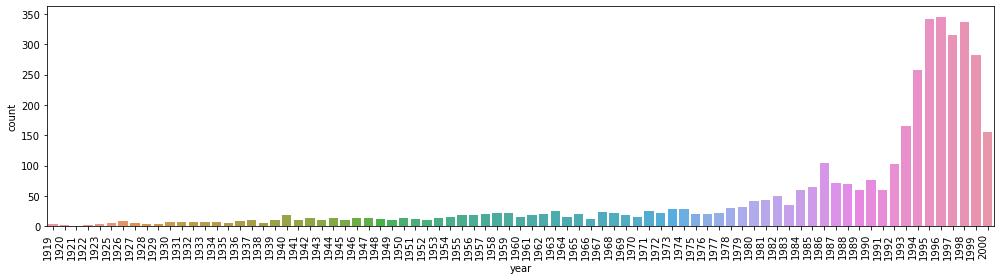

In [8]:
# Years with the highest number of movies release in the DB
from pyspark.sql.functions import split, regexp_extract, col, length, substring
import seaborn as snsat 
import matplotlib.pyplot as plt

moviesDFyear = moviesDF.withColumn('year', regexp_extract(col('movieName'), '\(([^)]*)\)[^(]*$', 1))

moviesByYearPd = moviesDFyear.groupBy('year').count().toPandas()
moviesByYearPd = moviesByYearPd.sort_values(by=['year'], ascending = True)

plt.figure(figsize=(14,4))
ax = snsat.barplot(x="year", y="count", data=moviesByYearPd)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

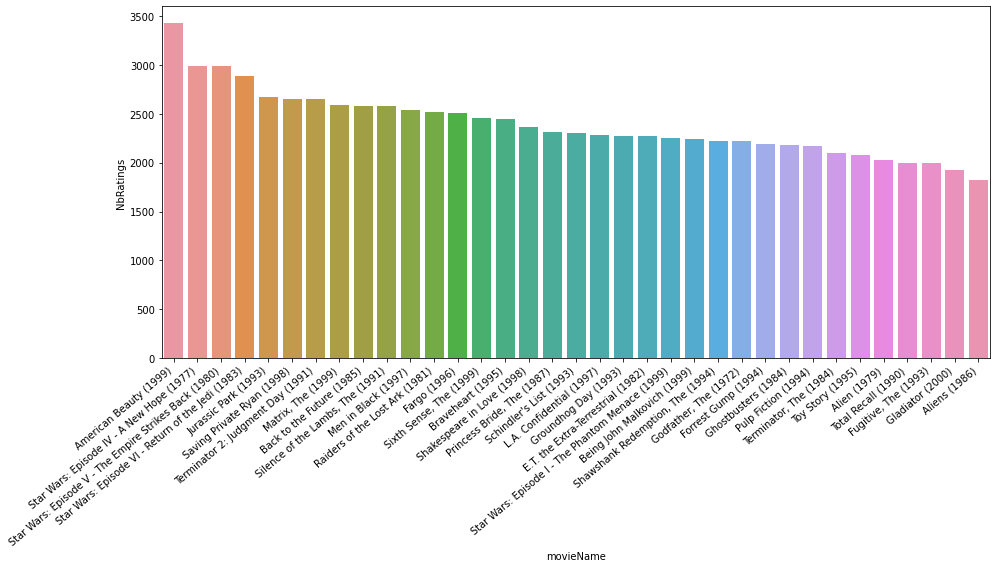

In [9]:
# Movies with the most important number of ratings

movies_ratingsDF = ratingsDF.join(moviesDF, 'movieId')
moviesByNbRate = movies_ratingsDF.groupby('movieId').count()
moviesByNbRate = moviesByNbRate.join(moviesDF, ['movieId'], 'left')
moviesByNbRate = moviesByNbRate.sort(moviesByNbRate['count'].desc()).withColumnRenamed('count', 'NbRatings' )

moviesByNbRatePd = moviesByNbRate.toPandas()
moviesByNbRatePd = moviesByNbRatePd.sort_values(by=['NbRatings'], ascending = True)
moviesByNbRatePd = moviesByNbRatePd.nlargest(35, columns='NbRatings')

plt.figure(figsize=(14,8))
ax = snsat.barplot(y="NbRatings", x="movieName", data=moviesByNbRatePd)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Pre-Processing

In [10]:
# Check if the ratings are consistent (between 0 and 5)
ratingsDF = ratingsDF.filter((ratingsDF.rating <= 5) & (ratingsDF.rating >= 0) )
print("Number of ratings out of the range [0 - 5]:", nbOfRatings - ratingsDF.count())

Number of ratings out of the range [0 - 5]: 0


In [11]:
# Check if there is not NaN value in the matrix rating
from pyspark.sql.functions import isnan, when, count, col
ratingsDF.select([count(when(isnan(c), c)).alias(c) for c in ratingsDF.columns]).show()

moviesDF.select([count(when(isnan(c), c)).alias(c) for c in moviesDF.columns]).show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      0|     0|
+------+-------+------+

+-------+---------+
|movieID|movieName|
+-------+---------+
|      0|        0|
+-------+---------+



In [12]:
# Drop dublicate rows
ratingsDF = ratingsDF.dropDuplicates()
print("Number of duplicate row for the rating dataset:", nbOfRatings - ratingsDF.count())

moviesDF = moviesDF.dropDuplicates()
print("Number of duplicate row the movies dataset:", nbOfMovies - moviesDF.count())

Number of duplicate row for the rating dataset: 0


Number of duplicate row the movies dataset: 0


# Implementation of the Machine Learning Prediction Part 1

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [14]:
# Create test and train set
(train, test) = ratingsDF.randomSplit([0.8, 0.2], seed = 5678)

In [15]:
# Create ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [16]:
# Add my movies ratings to the training database
trainWithMyRatings = train.union(myRatingsDF)

# Check if the ratings were correctly added
trainWithMyRatings.filter(trainWithMyRatings.userId == 0).show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      1|   5.0|
|     0|    780|   5.0|
|     0|    590|   5.0|
|     0|   1210|   5.0|
|     0|    648|   4.0|
|     0|    344|   1.0|
|     0|    165|   2.0|
|     0|    153|   2.0|
|     0|    597|   4.0|
|     0|   1580|   5.0|
|     0|    231|   2.0|
+------+-------+------+



In [17]:
# Train my model with my ratings
modelWithMyRatings = als.fit(trainWithMyRatings)

# Generate the predictions with the new model based on the test dataset
predictions = modelWithMyRatings.transform(test)

# Remove potential NaN number generated during the prediction
predictions = predictions.filter(predictions.prediction != float('nan'))

# Overview of the generated prediction
predictions.show(15)

21/10/16 11:29:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/16 11:29:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/16 11:29:23 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/16 11:29:23 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|  4784|    148|   3.0| 3.6053724|
|  1605|    148|   2.0|  2.480437|
|   840|    148|   1.0|  2.640998|
|   216|    148|   2.0| 3.2104535|
|   482|    148|   2.0| 4.0845118|
|   752|    148|   4.0| 3.8177094|
|   424|    148|   4.0| 3.2076116|
|  2456|    148|   2.0| 2.8767366|
|  3841|    463|   3.0| 3.5243313|
|  3650|    463|   2.0| 2.9931886|
|   319|    463|   2.0| 2.1309261|
|  5047|    463|   3.0| 2.7555351|
|  5306|    463|   2.0|  1.998049|
|  2210|    463|   3.0| 4.4559836|
|  4510|    463|   2.0| 1.9079659|
+------+-------+------+----------+
only showing top 15 rows



In [18]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

# Run the RMSE evaluator to check to quality of the new model
rmse = evaluator.evaluate(predictions)
print("The RMSE is", rmse)

The RMSE is 0.8891979830926231


In [19]:
# Generate the the recommendations.
# We are only looking for the top 5 of my recommended movies. The function recommendForAllUsers(x) find the x best recommandations. So we can use 5 as a parameter.
myRecommendations = modelWithMyRatings.recommendForAllUsers(5)

In [20]:
from pyspark.sql.functions import explode

# Cast the predictions into a dataframme well structure.
myRecommendations = myRecommendations.withColumn("rec_exp", explode("recommendations")).select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

# My ratings correspond to the user 0 so I have to filter my dataframe on userId = 0. Then I use the movie Dataframe to find the name of the movies id.
myRecommendationsList =  myRecommendations.filter(myRecommendations.userId == 0).join(moviesDF, ['movieId'], 'left')

# Display my top 5 movies
myRecommendationsList =  myRecommendations.filter(myRecommendations.userId == 0).join(moviesDF, ['movieId'], 'left').sort('rating', ascending=False).collect()
for i in range(0, 5):
  print(i + 1, ":", myRecommendationsList[i][3])

1 : I Am Cuba (Soy Cuba/Ya Kuba) (1964)
2 : You So Crazy (1994)
3 : From the Journals of Jean Seberg (1995)
4 : All the Rage (a.k.a. It's the Rage) (1999)
5 : Castle, The (1997)


# Implementation of the Machine Learning Prediction Part 2

In the part, we are going to try to generate a better ALS model. Using a list of parameters (instead of a set), we are going to try different tuning for our model, compare their RMSE and choose the most accurate model. By making more tries to find the best tuning, we hope generating a better model.

We will start this new part with the same train and test datasets

In [21]:
# Create ALS model
als2 = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")


In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Giving a list of parameter for the tuning instead of set of parameter
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [4, 12, 30, 60]) \
            .addGrid(als.regParam, [.01, .04, .1, .14]) \
            .build()

# Create a cross validation. The CrossValidator object will allows us to compare the RMSE ("evaluator" parameter) of our als2 model for each set of parameter.
cv2 = CrossValidator(estimator=als2, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# There are 2 parameters with 4 possible values for each one, which means 16 possible combinaisons of parameters.
print ("Number of possible models to be tested: ", len(param_grid))

Number of possible models to be tested:  16


In [23]:
# Train the model using the CrossValidator Object and the train dataset
model2 = cv2.fit(trainWithMyRatings)

# Extract best model from the cv model above
best_model2 = model2.bestModel

print("Best Model parameter:")
print("  Rank:", best_model2._java_obj.parent().getRank())
print("  RegParam:", best_model2._java_obj.parent().getRegParam())

Best Model parameter:
  Rank: 10
  RegParam: 0.1


In [24]:
# Generate the predictions with the new model based on the test data
predictions2 = best_model2.transform(test)
predictions2.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|  4784|    148|   3.0| 3.0642452|
|  1605|    148|   2.0| 2.2297986|
|   840|    148|   1.0| 2.6753983|
|   216|    148|   2.0| 2.4761913|
|   482|    148|   2.0| 2.6010926|
|   752|    148|   4.0| 3.0426629|
|   424|    148|   4.0| 2.9130206|
|  2456|    148|   2.0| 2.7770104|
|  3841|    463|   3.0| 2.6822438|
|  3650|    463|   2.0| 2.6182535|
|   319|    463|   2.0| 2.1724565|
|  5047|    463|   3.0| 2.4073944|
|  5306|    463|   2.0| 2.5796626|
|  2210|    463|   3.0| 2.8623059|
|  4510|    463|   2.0| 2.2323442|
|   721|    463|   4.0|  3.387203|
|  5511|    463|   2.0| 3.2944078|
|   331|    463|   4.0|   2.48739|
|  3829|    463|   2.0| 1.8953273|
|  1962|    463|   3.0|   1.94984|
+------+-------+------+----------+
only showing top 20 rows



In [25]:
# Run the previous RMSE evaluator to check to quality of the new model
rmse2 = evaluator.evaluate(predictions2)
print("The RMSE is", rmse2)

The RMSE is 0.8690734856973982


Using the same test dataset the RMSE lower than in the first part so our model is more accurate. Our recommendations are going to be more reliable than in the first part.

In [26]:
# Generate the the recommendations.
# We are only looking for the top 5 of my recommended movies. The function recommendForAllUsers(x) find the x best recommandations. So we can use 5 as a parameter.
myRecommendations2 = best_model2.recommendForAllUsers(5)

# Overview of the recommendations
myRecommendations2.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|  1580|[{572, 4.513469},...|
|  4900|[{572, 5.821749},...|
|  5300|[{572, 5.2067804}...|
|   471|[{572, 4.707136},...|
|  1591|[{572, 6.2328753}...|
|  4101|[{572, 5.118311},...|
|  1342|[{572, 4.8640623}...|
|  2122|[{572, 4.955928},...|
|  2142|[{572, 4.8442364}...|
|   463|[{2905, 4.155943}...|
|   833|[{572, 5.7941227}...|
|  5803|[{2483, 4.596774}...|
|  3794|[{572, 4.418244},...|
|  1645|[{572, 6.4532743}...|
|  3175|[{572, 4.931514},...|
|  4935|[{2776, 4.324355}...|
|   496|[{572, 5.77763}, ...|
|  2366|[{572, 4.8865275}...|
|  2866|[{572, 4.2841763}...|
|  5156|[{572, 5.6740103}...|
+------+--------------------+
only showing top 20 rows



In [27]:
# Cast the predictions into a dataframme well structure.
myRecommendations2 = myRecommendations2.withColumn("rec_exp", explode("recommendations")).select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

# My ratings correspond to the user 0 so I have to filter my dataframe on userId = 0. Then I use the movie Dataframe to find the name of the movies id.
myRecommendations2List =  myRecommendations2.filter(myRecommendations2.userId == 0).join(moviesDF, ['movieId'], 'left')

# Display my top 5 movies
myRecommendations2List =  myRecommendations2.filter(myRecommendations2.userId == 0).join(moviesDF, ['movieId'], 'left').sort('rating', ascending=False).collect()
for i in range(0, 5):
  print(i + 1, ":", myRecommendations2List[i][3])

1 : Leather Jacket Love Story (1997)
2 : Chushingura (1962)
3 : Third Miracle, The (1999)
4 : Foreign Student (1994)
5 : Star Wars: Episode IV - A New Hope (1977)


In [28]:
# clean up
sc.stop()